In [1]:
import sys
import numpy as np
import tensorflow as tf
#import matplotlib.pyplot as plt
# Generacion del grafico de metricas de Perdidas y Accuracy
import pandas as pd
import matplotlib.pyplot as plt
#ML
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout, Dense
from keras.applications import *
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as k
from keras.models import Model

Using TensorFlow backend.


In [2]:
# fix seed for reproducible results (only works on CPU, not GPU)
#seed = 9
#np.random.seed(seed=seed)
#tf.set_random_seed(seed=seed)

# parameters dependent on your dataset: modified to your example
nb_train_samples = 690  # Total number of train samples. NOT including augmented images
nb_validation_samples = 346  # Total number of train samples. NOT including augmented images.
img_width, img_height = 299, 299  # change based on the shape/structure of your images

# hyper parameters for model
based_model_last_block_layer_number = 172  # value is based on based model selected.
batch_size = 64#8  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 10#100  # number of iteration the algorithm gets trained.
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum

#Dataset
#data_dir = './data/DDSM Images'
data_dir = './data/DM images'
train_dir = data_dir + '/train'  # change to your train path. Inside, each class should have it's own folder
validation_dir = data_dir + '/validation'  # validation path. Inside, each class should have it's own folder

In [3]:
def train(train_data_dir, validation_data_dir):
    # Pre-Trained CNN Model using imagenet dataset for pre-trained weights
    base_model = InceptionV3(weights='imagenet', include_top=False)  # select from keras pre-built models library

    # Top Model Block
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)  # softmax if multi-class classifiers
    #predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer

    # add your top layer block to your base model
    model = Model(base_model.input, predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolution layers
    for layer in base_model.layers:
        layer.trainable = False

    # Read Data and Augment it: Make sure to select augmentations that are appropriate to your images.
    # To save augmentations un-comment save lines and add to your flow parameters.
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       #rotation_range=10,
                                       shear_range=.1,
                                       zoom_range=.1,
                                       cval=.1,
                                       horizontal_flip=True)
                                       #vertical_flip=True)

    validation_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='binary')
                                                        #save_to_dir=data_dir + '/preview',
                                                        #save_prefix='aug')#,
                                                        #save_format='jpeg')
    # use the above 3 commented lines if you want to save and look at how the data augmentations look like

    validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                            target_size=(img_height, img_width),
                                                            batch_size=batch_size,
                                                            class_mode='binary')

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])
    #  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

    # save weights of best training epoch: monitor either val_loss or val_acc
    top_weights_path = 'model/top_model_weights.h5'
    checkpoint = ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    callbacks_list = [checkpoint]

    # Train Simple CNN
    history_tl = model.fit_generator(train_generator,
                        samples_per_epoch=nb_train_samples,
                        nb_epoch=nb_epoch / 5,
                        validation_data=validation_generator,
                        nb_val_samples=nb_validation_samples,
                        callbacks=callbacks_list)

    # add the best weights from the train top model
    # at this point we have the pre-train weights of the base model and the trained weight of the new/added top model
    # we re-load model weights to ensure the best epoch is selected and not the last one.
    model.load_weights(top_weights_path)

    # verbose
    print("\nStarting to Fine Tune Model\n")

    # based_model_last_block_layer_number points to the layer in your model you want to train.
    # For example if you want to train the last block of a 19 layer VGG16 model this should be 15
    # If you want to train the last TWO blocks of an Inception model it should be 172
    # layers before this number will used the pre-trained weights, layers above and including this number
    # will be re-trained based on the new data.
    for layer in model.layers[:based_model_last_block_layer_number]:
        layer.trainable = False
    for layer in model.layers[based_model_last_block_layer_number:]:
        layer.trainable = True

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss='binary_crossentropy',
                  optimizer=SGD(lr=learn_rate, momentum=momentum),
                  metrics=['accuracy'])

    # save weights of best training epoch: monitor either val_loss or val_acc
    path_dir = data_dir.split('/')
    name_dir = path_dir[len(path_dir)-1]
    final_weights_path = 'model/model_weights_'+name_dir+'.h5'
    checkpoint = ModelCheckpoint(final_weights_path, monitor='val_loss', verbose=1, save_best_only=True, mode='mode')
    callbacks_list = [checkpoint]

    # fine-tune the model
    history_ft = model.fit_generator(train_generator,
                        samples_per_epoch=nb_train_samples,
                        nb_epoch=nb_epoch,
                        validation_data=validation_generator,
                        nb_val_samples=nb_validation_samples,
                        callbacks=callbacks_list)
    
    # save model
    model_json = model.to_json()
    with open('model/model'+name_dir+'.json', 'w') as json_file:
        json_file.write(model_json)
        
    return history_tl, history_ft, model


hist_tl, hist_ft, model_layers = train(train_dir, validation_dir)  # train model

Found 80 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


/home/grupoavatar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:63: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/grupoavatar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=10, validation_steps=346, callbacks=[<keras.ca..., epochs=2.0)`


Epoch 1/2
10/10 [==============================] - 144s 14s/step - loss: 1.4768 - acc: 0.6341 - val_loss: 1.7418 - val_acc: 0.7500
Epoch 2/2
10/10 [==============================] - 130s 13s/step - loss: 0.7394 - acc: 0.7168 - val_loss: 0.8730 - val_acc: 0.7500

Starting to Fine Tune Model



/home/grupoavatar/.local/lib/python3.5/site-packages/keras/callbacks.py:375: RuntimeWarning: ModelCheckpoint mode mode is unknown, fallback to auto mode.
  RuntimeWarning)
/home/grupoavatar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:102: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/grupoavatar/.local/lib/python3.5/site-packages/ipykernel_launcher.py:102: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=10, validation_steps=346, callbacks=[<keras.ca..., epochs=10)`


Epoch 1/10
10/10 [==============================] - 135s 13s/step - loss: 1.6693 - acc: 0.6861 - val_loss: 1.6004 - val_acc: 0.7500
Epoch 2/10
10/10 [==============================] - 137s 14s/step - loss: 1.0533 - acc: 0.7448 - val_loss: 1.3550 - val_acc: 0.7500
Epoch 3/10
10/10 [==============================] - 136s 14s/step - loss: 0.9156 - acc: 0.7516 - val_loss: 1.1106 - val_acc: 0.7500
Epoch 4/10
10/10 [==============================] - 137s 14s/step - loss: 0.8688 - acc: 0.7261 - val_loss: 0.8829 - val_acc: 0.7500
Epoch 5/10
10/10 [==============================] - 130s 13s/step - loss: 0.6400 - acc: 0.7434 - val_loss: 0.7387 - val_acc: 0.7500
Epoch 6/10
10/10 [==============================] - 130s 13s/step - loss: 0.5999 - acc: 0.7514 - val_loss: 0.6640 - val_acc: 0.7500
Epoch 7/10
10/10 [==============================] - 130s 13s/step - loss: 0.5115 - acc: 0.7661 - val_loss: 0.6328 - val_acc: 0.7500
Epoch 8/10
10/10 [==============================] - 129s 13s/step - loss: 0.

In [4]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze: this is used to define based_model_last_block_layer_number
for i, layer in enumerate(model_layers):  # comment these two lines once the correct based_model_last_block_layer
    print(i, layer.name)  # has been selected

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

/home/grupoavatar/.local/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label
/home/grupoavatar/.local/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


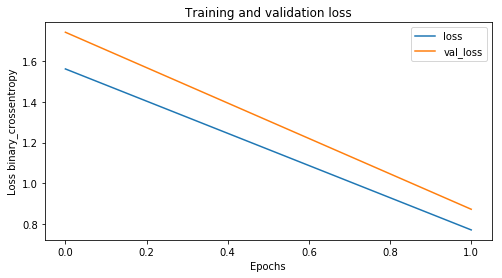

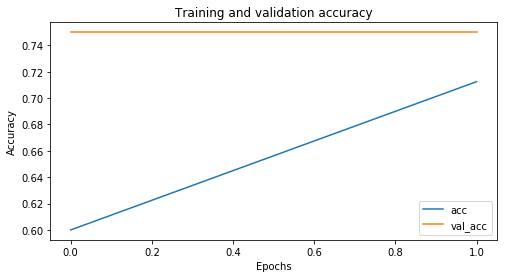

In [5]:
def plot_training2(history):
    #% matplotlib inline

    df = pd.DataFrame(history.history)
    # display(df)

    plot = df.plot(y=['loss', 'val_loss'], figsize=(8, 4), title='Training and validation loss', legend=True)
    plot.set_xlabel('Epochs')
    plot.set_ylabel('Loss binary_crossentropy')    
    fig = plot.get_figure()
    fig.savefig('loss_graph_t_cancer_t:'+str(nb_train_samples)+'smp_v:'+str(nb_validation_samples)+'smp_'+str(nb_epoch)+'epc.png')

    plot = df.plot(y=['acc', 'val_acc'], figsize=(8, 4), title='Training and validation accuracy', legend=True)
    plot.set_xlabel('Epochs')
    plot.set_ylabel('Accuracy')
    fig = plot.get_figure()
    fig.savefig('acc_graph_t_cancer_t:'+str(nb_train_samples)+'smp_v:'+str(nb_validation_samples)+'smp_'+str(nb_epoch)+'epc.png')
    
    plt.show()

#Transfer Learning    
plot_training2(hist_tl)

/home/grupoavatar/.local/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


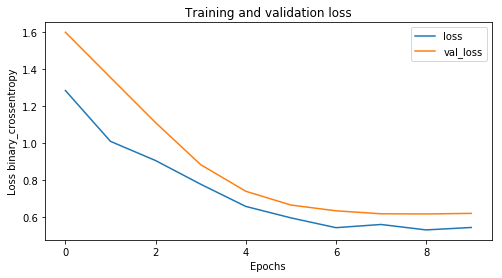

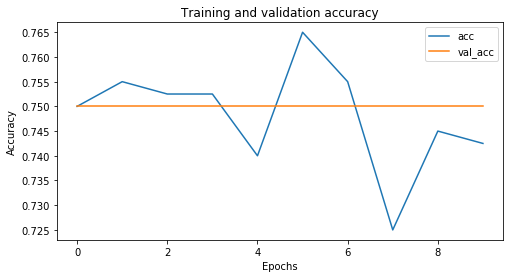

In [6]:
#Finetune
plot_training2(hist_ft)

In [9]:
#print(len(model.layers))
#model2 = Model(model)
#hist_val = model2.validate()
#plot_training2(hist_val)

path_dir = data_dir.split('/')
name_dir = path_dir[len(path_dir)-1]

# save model
model_json = model.to_json()
with open('model/model'+name_dir+'.json', 'w') as json_file:
    json_file.write(model_json)
    
# load json and create model
json_file = open('model/model'+name_dir+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


315


TypeError: __init__() missing 1 required positional argument: 'outputs'

In [ ]:
# release memory
k.clear_session()